In [1]:
import copy
from copy import deepcopy
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D , LSTM, Attention
from tensorflow.keras.losses import *
from tensorflow.keras.optimizers import*
import random as random
import time
import matplotlib.pyplot as plt

import Seth
from Seth import fetch_seth, Devices, Floorplan, get_mac_ids

Init Plugin
Init Graph Optimizer
Init Kernel


In [73]:
def train_data():
    # dfs is a list of dataframes
# meta is a dataframe with meta data

#getting train data
    train_fp, train_meta = fetch_seth(
    Devices.s7,
    Floorplan.OFFICE,
    ci = 0,
    base_path="temp/clean/"  # <-- this would be 'seth/temp/clean' from outside this dir
)
    train_fp = train_fp.sample(frac=1).reset_index(drop=True)
    train_aps = get_mac_ids(train_fp.columns)
    train_x = train_fp[train_aps].values
    train_x = (train_x + 100)/100
    train_y = (train_fp["label"]).values
    return train_x, train_y, train_aps

In [74]:
def mean_cal(group):
    for i in range (0, len(group)):
        if group[i] < 0:
            group[i] = -group [i]
    mean_diff = np.mean(group)
    return mean_diff

In [75]:
# print(train_x.shape)
# train_x.reshape( 1,366, 206 )
# a = train_x.flatten()
# print(a.shape)

In [76]:
train_x, train_y, train_aps = train_data()
np.unique(train_y).shape


(48,)

In [77]:


num_classes = 48
callbacks = [tf.keras.callbacks.EarlyStopping(patience=300)]

error = []
mean_error = []

model = Sequential()
model.add(Flatten(input_dim=train_x.shape[1]))
#model.add(Conv1D(32, 1, padding='same', activation='relu', input_shape=(train_x.shape[0],train_x.shape[1])))
#model.add(MaxPooling1D())
#model.add(Flatten())
model.add(tf.keras.layers.GaussianNoise(0.15))
model.add(Dropout(0.2))
# model.add(Dense(32, input_dim=203, activation='relu'))
# model.add(Dropout(0.2))

model.add(Dense(32, activation='selu'))
model.add(Dropout(0.2))

model.add(Dense(64, activation='selu'))
model.add(Dropout(0.2))

model.add(Dense(128, activation='selu'))
model.add(Dropout(0.2))

model.add(Dense(num_classes, activation='softmax'))

# model.summary()

opt = Adam(learning_rate=1e-4)

model.compile(loss=sparse_categorical_crossentropy,
            optimizer=opt,
            metrics=['accuracy'])
            

model.fit(train_x, train_y,
        epochs=3000,
        callbacks = callbacks,
        validation_split = 0.2,
        verbose=1)

model.save('DNN_s7_office')

Epoch 1/3000


2022-02-22 23:59:38.015185: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 1s 36ms/step - loss: 4.1061 - accuracy: 0.0304 - val_loss: 3.9696 - val_accuracy: 0.0000e+00
Epoch 2/3000
6/8 [=====================>........] - ETA: 0s - loss: 4.0305 - accuracy: 0.0312

2022-02-22 23:59:38.465112: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 0s 13ms/step - loss: 4.0489 - accuracy: 0.0304 - val_loss: 3.9656 - val_accuracy: 0.0000e+00
Epoch 3/3000
8/8 [==============================] - 0s 13ms/step - loss: 4.0408 - accuracy: 0.0130 - val_loss: 3.9619 - val_accuracy: 0.0000e+00
Epoch 4/3000
8/8 [==============================] - 0s 11ms/step - loss: 4.0317 - accuracy: 0.0435 - val_loss: 3.9575 - val_accuracy: 0.0000e+00
Epoch 5/3000
8/8 [==============================] - 0s 12ms/step - loss: 4.0036 - accuracy: 0.0174 - val_loss: 3.9531 - val_accuracy: 0.0000e+00
Epoch 6/3000
8/8 [==============================] - 0s 26ms/step - loss: 4.0513 - accuracy: 0.0087 - val_loss: 3.9492 - val_accuracy: 0.0000e+00
Epoch 7/3000
8/8 [==============================] - 0s 14ms/step - loss: 4.0706 - accuracy: 0.0087 - val_loss: 3.9452 - val_accuracy: 0.0000e+00
Epoch 8/3000
8/8 [==============================] - 0s 12ms/step - loss: 4.0273 - accuracy: 0.0087 - val_loss: 3.9427 - val_accuracy: 0.0000e+0

In [89]:
def test_data(itr, train_aps):
    #getting test data
    test_fp, test_meta = fetch_seth(
    Devices.op3 ,
    Floorplan.OFFICE,
    ci = itr,
    base_path="temp/clean/"  # <-- this would be 'seth/temp/clean' from outside this dir
)
    test_aps = get_mac_ids(test_fp.columns)
    missing_aps = list(set(train_aps)-set(test_aps))
    test_fp[missing_aps] = -100
    test_x = test_fp[train_aps].values
    test_x = (test_x + 100)/100
    test_y = (test_fp["label"]).values
    return test_x, test_y


In [79]:
mean_error=[]

In [90]:
#devices = ['Devices.lg', 'Devices.blu', 'Devices.htc', 'Devices.moto', 'Devices.s7', 'Devices.op3']
#for dev in devices:
#print(dev)
test_x, test_y = test_data(0, train_aps)
pred = np.argmax(model.predict(test_x), axis=1)
acc = sum([(test_y[i])==(pred[i]) for i in range(228)])/228
print('Test accuracy:', acc)


for i in range (0, len(pred)):
    error.append(test_y[i]-pred[i])
    
mean_error.append([mean_cal(error)])

# lg , blu, htc, moto, s7
# office
print("Mean Error  = ", mean_error)

Test accuracy: 0.21929824561403508
Mean Error  =  [[1.4375], [1.4947916666666667], [1.3993055555555556], [1.4939236111111112], [1.2215277777777778], [1.2725694444444444]]


In [ ]:
new_office = [[0.20833333333333334, 0.9861111111111112, 1.1712962962962963, 1.453125, 1.4743055555555555, 1.546875],
[1.6354166666666667, 0.921875, 1.1539351851851851, 1.3029513888888888, 1.2972222222222223, 1.3501157407407407],
[1.2152777777777777, 1.4635416666666667, 0.971875, 1.2717013888888888, 1.2631944444444445, 1.2575231481481481],
[1.9756944444444444, 1.8107638888888888, 1.8425925925925926, 1.2017361111111112, 1.5020833333333334, 1.478587962962963],
[1.4375, 1.4947916666666667, 1.3993055555555556, 1.4939236111111112, 1.2115277777777778, 1.2725694444444444],
[]]

In [25]:
new_basement = [[0.226775956284153, 1.150273224043716, 1.1429872495446265, 1.3346994535519126, 1.387431693989071, 1.4781420765027322],
[1.4508196721311475, 0.889344262295082, 1.0154826958105647, 1.1898907103825136, 1.219672131147541, 1.2914389799635702],
[1.2475409836065573, 1.5136612021857923, 1.1402550091074681, 1.4439890710382515, 1.4295081967213115, 1.5728597449908925],
[1.5327868852459017, 1.46448087431694, 1.3852459016393444, 1.0866510538641687, 1.181967213114754, 1.1930783242258651],
[1.289617486338798, 1.4795081967213115, 1.4754098360655739, 1.6202185792349726, 1.2053083528493365, 1.3642987249544627],
[1.9836065573770492, 1.7308743169398908, 1.6958105646630237, 1.6441256830601092, 1.616393442622951, 1.1020947176684881]]

In [108]:
heatmap_data_basement = [[10.08287795992714, 10.219945355191257, 10.387978142076502, 10.12295081967213, 10.21311475409836, 10.198087431693988],
[15.092896174863387, 14.221311475409836, 14.349726775956285, 14.147540983606557, 14.198907103825137, 14.091985428051002],
[11.576502732240437, 11.337431693989071, 11.274134790528233, 11.262978142076502, 11.321311475409836, 11.342440801457196],
[15.59016393442623, 14.19672131147541, 14.258652094717668, 13.990437158469945, 14.198907103825137, 14.02823315118397],
[15.382513661202186, 14.489071038251366, 14.26047358834244, 14.083333333333334, 14.101639344262296, 14.018214936247723],
[6.942622950819672, 6.709016393442623, 6.798724954462659, 6.7103825136612025, 6.742622950819672, 6.65528233151184]]

In [109]:
heatmap_data_office= [[0.08680555555555555,0.6293402777777778, 0.7722222222222223, 1.0081018518518519, 1.0793650793650793, 1.2230902777777777], [1.7430555555555556, 0.9305555555555556, 1.2615740740740742, 1.3958333333333333, 1.4097222222222223, 1.4184027777777777],
[1.4479166666666667, 1.5555555555555556,1.0601851851851851, 1.2612847222222223, 1.2826388888888889, 1.359375], [2.3541666666666665, 2.4340277777777777, 2.4293981481481484, 1.8845486111111112, 1.90625, 1.8935185185185186],
[1.3854166666666667, 1.4930555555555556, 1.412037037037037, 1.4409722222222223, 1.1611111111111112, 1.2268518518518519], [2.361111111111111, 2.0538194444444446, 2.0439814814814814, 1.9522569444444444, 1.836111111111111, 1.5439814814814814]]

In [21]:
import seaborn as sb

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


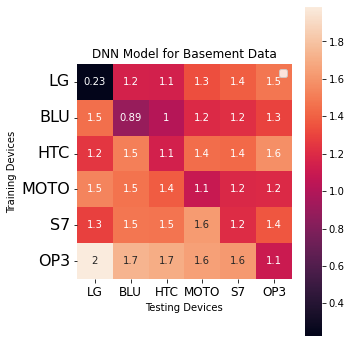

In [26]:
fig, ax = plt.subplots(figsize=(5,5))
x_axis_labels = ['LG','BLU','HTC','MOTO','S7','OP3'] # labels for x-axis
y_axis_labels = ['LG','BLU','HTC','MOTO','S7','OP3'] # labels for y-axis
sb.heatmap(new_basement, xticklabels=x_axis_labels, yticklabels=y_axis_labels,annot=True, square=True, ax=ax)
plt.title("DNN Model for Basement Data")
plt.xlabel('Testing Devices',)
plt.ylabel('Training Devices',)
plt.yticks(rotation=0,fontsize=16);
plt.xticks(fontsize=12);
plt.legend()
plt.tight_layout()
plt.savefig("DNN_heatmap_basement.png")
plt.show()